In [ ]:
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
%matplotlib inline
from google.colab import drive

In [ ]:
drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/Shareddrives/PokémonSerina/All_Pokemons"
result_path_csv = "/content/drive/Shareddrives/PokémonSerina/SVM_Results_Axel/SVM_csv"
result_path_roc_curve = "/content/drive/Shareddrives/PokémonSerina/SVM_Results_Axel/SVM_ROC_Curves"

Mounted at /content/drive


In [ ]:
def get_pokemon_names(path):
  return os.listdir(path)

In [ ]:
def read_images(data_path, pokemon_1, pokemon_2, pokedex_number_1, pokedex_number_2):
  sprite_paths_1 = glob.glob(data_path + '/{}.{}/*.jpg'.format(pokedex_number_1, pokemon_1))
  sprite_paths_2 = glob.glob(data_path + '/{}.{}/*.jpg'.format(pokedex_number_2, pokemon_2))
  label_1 = 0
  label_2 = 1
  sprites = []
  labels = []
  for path in sprite_paths_1:
    img_array=imread(path)
    img_resized=resize(img_array,(80, 80, 3))
    sprites.append(img_resized.flatten())
    labels.append(label_1)
  for path in sprite_paths_2:
    img_array = imread(path)
    img_resized = resize(img_array, (80, 80, 3))
    sprites.append(img_resized.flatten())
    labels.append(label_2)
  return sprites, labels

In [ ]:
def create_dataset(sprites, labels):
  df = pd.DataFrame(sprites)
  df['Target'] = labels
  x = df.iloc[:, :-1]
  y = df.iloc[:,-1]
  return x, y

In [ ]:
from sklearn.decomposition import PCA
def reduce_dimension(dataset):
  pca = PCA(n_components=0.98)
  dataset_reduced = pca.fit_transform(dataset)
  return dataset_reduced

In [ ]:
from sklearn.model_selection import train_test_split
def split_train_test(x, y, test_set_size=0.2):
  x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=test_set_size, random_state=42, stratify=y)
  
  return x_train, x_test, y_train, y_test

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
def train_svm_model(x_train, y_train):
  param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly', 'linear']}
  svc = SVC(probability=True)
  model = GridSearchCV(svc,param_grid)
  model.fit(x_train, y_train)
  y_train_pred = cross_val_predict(model, x_train, y_train, cv=3)
  return model, y_train_pred

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
def train_rf_model(x_train, y_train):
  param_grid = {'n_estimators':[100, 300, 500],'criterion': ['gini', 'entropy']}
  rf = RandomForestClassifier(random_state=42)
  model = GridSearchCV(rf,param_grid)
  model.fit(x_train, y_train)
  y_train_pred = cross_val_predict(model, x_train, y_train, cv=3)
  return model, y_train_pred

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
def train_bagging_model(x_train, y_train):
  param_grid = {'n_estimators':[100, 300, 500],'max_samples': [0.5, 1.0], 'bootstrap': [True, False]}
  bagging = BaggingClassifier(DecisionTreeClassifier(), random_state=42)
  model = GridSearchCV(bagging,param_grid)
  model.fit(x_train, y_train)
  y_train_pred = cross_val_predict(model, x_train, y_train, cv=3)
  return model, y_train_pred

In [ ]:
from sklearn.model_selection import cross_val_score
def compute_y_scores(model, x_train, y_train, bin_size = 3):
  try:
    y_scores = cross_val_predict(model, x_train, y_train, cv=bin_size, method='decision_function')
  except:
    y_scores = cross_val_predict(model, x_train, y_train, cv=bin_size, method='predict_proba')[:,1]
  return y_scores

In [ ]:
from sklearn.metrics import precision_score, recall_score
def compute_precision_recall(y_true, y_pred):
  precision = precision_score(y_true, y_pred) #true bulbasaur / true bulbasaur + false bulbsaur
  recall = recall_score(y_true, y_pred) #true bulbsaur / true bulbsaur + false ivysaur
  return precision, recall

In [ ]:
from sklearn.metrics import f1_score
def compute_f1_score(y_true, y_pred):
  f1 = f1_score(y_true, y_pred)
  return f1

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

In [ ]:
def get_save_path(result_path_roc_cure, pokemon_name, pokedex_number):
  dir_name = "{}.{}".format(pokedex_number, pokemon_name)
  curve_path = result_path_roc_curve + "/" + dir_name
  try:
    os.mkdir(curve_path)
  except:
    pass
  return curve_path

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
def show_roc_score(y_true, y_scores, pokemon_1, pokemon_2, pokedex_number_1, pokedex_number_2, result_path_roc_curve):
  precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
  recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
  fpr, tpr, thresholds = roc_curve(y_train, y_scores)
  plt.figure(figsize=(8, 6))
  plot_roc_curve(fpr, tpr)
  fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
  plt.title('{} vs {}'.format(pokemon_1, pokemon_2), fontsize=16)
  plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
  plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
  plt.plot([fpr_90], [recall_90_precision], "ro")
  path_1 = get_save_path(result_path_roc_curve, pokemon_1, pokedex_number_1)
  path_2 = get_save_path(result_path_roc_curve, pokemon_2, pokedex_number_2)
  # path_1_rf = get_save_path(result_path_roc_curve_rf, pokemon_1, pokedex_number_1)
  # path_2_rf = get_save_path(result_path_roc_curve_rf, pokemon_2, pokedex_number_2)
  # path_1_bagging = get_save_path(result_path_roc_curve_bagging, pokemon_1, pokedex_number_1)
  # path_2_bagging = get_save_path(result_path_roc_curve_bagging, pokemon_2, pokedex_number_2)
  plt.savefig(path_1 + "/{}_vs_{}.jpg".format(pokemon_1, pokemon_2))
  plt.savefig(path_2 + "/{}_vs_{}.jpg".format(pokemon_2, pokemon_1))
  # plt.savefig(path_1_rf + "/{}_vs_{}.jpg".format(pokemon_1, pokemon_2))
  # plt.savefig(path_2_rf + "/{}_vs_{}.jpg".format(pokemon_2, pokemon_1))
  # plt.savefig(path_1_bagging + "/{}_vs_{}.jpg".format(pokemon_1, pokemon_2))
  # plt.savefig(path_2_bagging + "/{}_vs_{}.jpg".format(pokemon_2, pokemon_1))
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
def compute_roc_auc(y_true, y_scores):
  return roc_auc_score(y_train, y_scores)

In [ ]:
from sklearn.metrics import confusion_matrix
def compute_confusion_matrix(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred)
  return conf_matrix

In [ ]:
from sklearn.metrics import accuracy_score
def compute_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [ ]:
def create_file_svm(path):
  with open(path, 'w') as f:
    f.write("Pokemon_1, Pokemon_2, #Pokemon_1_Train, #Pokemon_2_Train, #Pokemon_1_Test, #Pokemon_2_Test, Precision, Recall, F1, AUC, Accuracy, #Pokemon_2_Miss_Pokemon_1, #Pokemon_1_Miss_Pokemon_2, C, Gamma, Kernel\n")

In [ ]:
def save_data_to_csv_svm(path, data):
  complete_path = path + "/" + "Results5.csv"
  if not os.path.isfile(complete_path):
    create_file_svm(complete_path)
  with open(complete_path, 'a') as f:
    f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}\n".format(data['pokemon_1'], data['pokemon_2'],
                                                                              data['pokemon_1_total_train'], data['pokemon_2_total_train'],
                                                                              data['pokemon_1_total_test'], data['pokemon_2_total_test'],
                                                                              data['precision'], data['recall'], data['f1'], data['roc_auc'], data['accuracy'],
                                                                              data['pokemon_2_miss_pokemon_1'], data['pokemon_1_miss_pokemon_2'],
                                                                              data['C'], data['Gamma'], data['Kernel']))

In [ ]:
pokemon_names = get_pokemon_names(data_path)
for i in range(73,len(pokemon_names)):
  for j in range(i + 1, len(pokemon_names)):
    data_to_save_svm = {}
    pokemon_name_1 = pokemon_names[i]
    pokemon_name_2 = pokemon_names[j]
    pokemon_1 = pokemon_name_1.split('.')[1]
    pokemon_2 = pokemon_name_2.split('.')[1]
    pokedex_number_1 = int(pokemon_name_1.split('.')[0])
    pokedex_number_2 = int(pokemon_name_2.split('.')[0])
    print("Comparing {} with {}".format(pokemon_1, pokemon_2))
    #preparing the data
    sprites, labels = read_images(data_path, pokemon_1, pokemon_2, pokedex_number_1, pokedex_number_2)
    x, y = create_dataset(sprites, labels)
    x_reduced = reduce_dimension(x)
    x_train, x_test, y_train, y_test = split_train_test(x_reduced, y)
    #train the model
    model_svm, y_train_pred_svm = train_svm_model(x_train, y_train)
    #evaluating the model
    y_scores_svm = compute_y_scores(model_svm, x_train, y_train)
    #precision, recall, f1, df2, roc_curve and auc
    precision_svm, recall_svm = compute_precision_recall(y_train, y_train_pred_svm)
    f1_svm = compute_f1_score(y_train, y_train_pred_svm)

    show_roc_score(y_train, y_scores_svm, pokemon_1, pokemon_2, pokedex_number_1, pokedex_number_2, result_path_roc_curve)

    roc_auc_svm = compute_roc_auc(y_train, y_scores_svm)
    #make predictions
    y_pred_svm = model_svm.predict(x_test)
    #confusion matrices just to know how many data we have
    train_confusion_matrix_svm = compute_confusion_matrix(y_train, y_train_pred_svm)
    test_confusion_matrix_svm = compute_confusion_matrix(y_test, y_pred_svm)
    #evaluating how much the model is confusing
    pokemon_2_miss_pokemon_1_svm = train_confusion_matrix_svm[0][1]
    pokemon_1_miss_pokemon_2_svm = train_confusion_matrix_svm[1][0]
    #accuracy
    accuracy_svm = compute_model_accuracy(y_test, y_pred_svm)
    #saving the data in a csv file
    pokemon_1_total_train = train_confusion_matrix_svm[0][0] + train_confusion_matrix_svm[0][1]
    pokemon_2_total_train = train_confusion_matrix_svm[1][0] + train_confusion_matrix_svm[1][1]
    pokemon_1_total_test = test_confusion_matrix_svm[0][0] + test_confusion_matrix_svm[0][1]
    pokemon_2_total_test = test_confusion_matrix_svm[1][0] + test_confusion_matrix_svm[1][1]

    data_to_save_svm['pokemon_1'] = pokemon_1; data_to_save_svm['pokemon_2'] = pokemon_2
    data_to_save_svm['pokemon_1_total_train'] = pokemon_1_total_train; data_to_save_svm['pokemon_2_total_train'] = pokemon_2_total_train
    data_to_save_svm['pokemon_1_total_test'] = pokemon_1_total_test; data_to_save_svm['pokemon_2_total_test'] = pokemon_2_total_test
    data_to_save_svm['precision'] = precision_svm; data_to_save_svm['recall'] = recall_svm
    data_to_save_svm['f1'] = f1_svm
    data_to_save_svm['roc_auc'] = roc_auc_svm
    data_to_save_svm['accuracy'] = accuracy_svm
    data_to_save_svm['pokemon_2_miss_pokemon_1'] = pokemon_2_miss_pokemon_1_svm; data_to_save_svm['pokemon_1_miss_pokemon_2'] = pokemon_1_miss_pokemon_2_svm
    data_to_save_svm['C'] = model_svm.best_params_['C']; data_to_save_svm['Gamma'] = model_svm.best_params_['gamma']; data_to_save_svm['Kernel'] = model_svm.best_params_['kernel'];

    save_data_to_csv_svm(result_path_csv, data_to_save_svm)

Output hidden; open in https://colab.research.google.com to view.

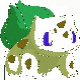

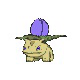

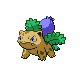

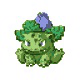

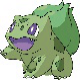

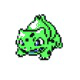

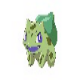

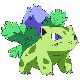

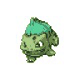

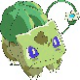

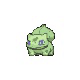

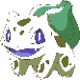

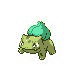

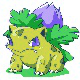

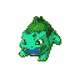

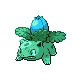

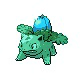

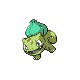

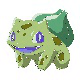

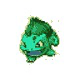

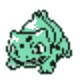

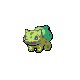

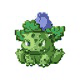

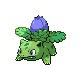

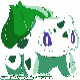

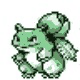

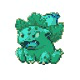

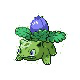

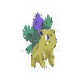

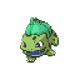

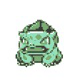

In [ ]:
for i in range(len(x_test)):
  test_image = np.array(x_test_original.iloc[i] * 255).reshape(80,80,3)
  cv2_imshow(test_image)

In [ ]:
df = pd.read_csv(result_path_csv + "/" + "Results.csv")
df.iloc[9999]

Unnamed: 0                    Exeggcute
Unnamed: 0.1                    Drowzee
Unnamed: 0.1.1                       47
Pokemon_1                            43
 Pokemon_2                           12
 #Pokemon_1_Train                    11
 #Pokemon_2_Train                     1
 #Pokemon_1_Test               0.976744
 #Pokemon_2_Test               0.988235
 Precision                     0.997031
 Recall                               1
 F1                                   0
 AUC                                  1
 Accuracy                           NaN
 #Pokemon_2_Miss_Pokemon_1          NaN
 #Pokemon_1_Miss_Pokemon_2          NaN
Name: 9999, dtype: object

In [ ]:
new_df = df.drop(np.arange(9999, 10009))
new_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Pokemon_1,Pokemon_2,#Pokemon_1_Train,#Pokemon_2_Train,#Pokemon_1_Test,#Pokemon_2_Test,Precision,Recall,F1,AUC,Accuracy,#Pokemon_2_Miss_Pokemon_1,#Pokemon_1_Miss_Pokemon_2
0,0,0,0,Bulbasaur,Ivysaur,70,54.000000,18.000000,13.000000,0.980000,0.907407,0.942308,0.965608,0.870968,1.0,5.0
1,1,1,1,Bulbasaur,Venusaur,70,61.000000,18.000000,15.000000,0.982456,0.918033,0.949153,0.992272,1.000000,1.0,5.0
2,2,2,2,Bulbasaur,Squirtle,70,106.000000,18.000000,27.000000,0.920354,0.981132,0.949772,0.970216,0.977778,9.0,2.0
3,3,3,3,Bulbasaur,Caterpie,70,50.000000,18.000000,13.000000,0.884615,0.920000,0.901961,0.972000,0.967742,6.0,4.0
4,4,4,4,Bulbasaur,Mew,70,59.000000,18.000000,15.000000,0.935484,0.983051,0.958678,0.978935,1.000000,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Hypno,Dragonite,60,48,15,13,0.900000,0.937500,0.918367,0.987847,1.000000,5.000000,3.000000,NaN,NaN,NaN
9995,Hypno,Articuno,60,48,15,13,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN
9996,Hypno,Moltres,60,55,15,14,0.881356,0.945455,0.912281,0.983030,1.000000,7.000000,3.000000,NaN,NaN,NaN
9997,Hypno,Charmander,60,108,15,28,0.923077,1.000000,0.960000,0.984568,0.976744,9.000000,0.000000,NaN,NaN,NaN


In [ ]:
new_df.to_csv(result_path_csv + "/Results.csv")

In [ ]:
new_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Pokemon_1,Pokemon_2,#Pokemon_1_Train,#Pokemon_2_Train,#Pokemon_1_Test,#Pokemon_2_Test,Precision,Recall,F1,AUC,Accuracy,#Pokemon_2_Miss_Pokemon_1,#Pokemon_1_Miss_Pokemon_2
0,0,0,0,Bulbasaur,Ivysaur,70,54.000000,18.000000,13.000000,0.980000,0.907407,0.942308,0.965608,0.870968,1.0,5.0
1,1,1,1,Bulbasaur,Venusaur,70,61.000000,18.000000,15.000000,0.982456,0.918033,0.949153,0.992272,1.000000,1.0,5.0
2,2,2,2,Bulbasaur,Squirtle,70,106.000000,18.000000,27.000000,0.920354,0.981132,0.949772,0.970216,0.977778,9.0,2.0
3,3,3,3,Bulbasaur,Caterpie,70,50.000000,18.000000,13.000000,0.884615,0.920000,0.901961,0.972000,0.967742,6.0,4.0
4,4,4,4,Bulbasaur,Mew,70,59.000000,18.000000,15.000000,0.935484,0.983051,0.958678,0.978935,1.000000,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Hypno,Dragonite,60,48,15,13,0.900000,0.937500,0.918367,0.987847,1.000000,5.000000,3.000000,NaN,NaN,NaN
9995,Hypno,Articuno,60,48,15,13,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN
9996,Hypno,Moltres,60,55,15,14,0.881356,0.945455,0.912281,0.983030,1.000000,7.000000,3.000000,NaN,NaN,NaN
9997,Hypno,Charmander,60,108,15,28,0.923077,1.000000,0.960000,0.984568,0.976744,9.000000,0.000000,NaN,NaN,NaN


In [ ]:
model_svm.best_params_['C']

1

In [ ]:
recall_bagging

0.7962962962962963

In [ ]:
y_scores_svm

array([ 0.19027616, -0.91481629, -1.54879497, -1.09677794,  0.34559507,
       -0.86113621, -0.66060063, -0.85134674, -0.22132654,  1.23467965,
       -0.98035131, -0.44349717, -0.31407838,  0.57094255, -0.03002852,
        0.68455328, -0.99214284, -0.33604032, -0.53295735, -0.40626242,
       -1.09667832,  0.2431637 , -1.27186732,  0.27032161,  0.9123868 ,
       -1.09168658, -1.07789639, -0.19926551, -0.68505055,  0.68981855,
       -0.99137504, -0.69000387, -0.60893436, -0.48560335,  0.83906435,
       -0.97822077, -0.96797082, -0.41578967, -0.8812384 , -0.53771912,
        0.56031707, -0.64784517, -0.55653807,  0.96973675,  0.75774908,
        0.01932458, -1.00204851, -0.85343831,  0.90879711, -0.10118786,
       -0.96456189, -0.20544475,  0.90075914, -0.28462313,  0.22449292,
       -0.65024757, -0.78975776,  1.06508875, -1.03089119,  0.06803807,
       -1.02350854, -0.75780599, -0.0790778 ,  0.2215436 , -0.24966362,
        0.28082589, -0.99420934,  0.90425923, -0.64749743,  0.98

In [ ]:
compute_y_scores(model_rf, x_train, y_train)[:,1]

array([[0.502     , 0.498     ],
       [0.782     , 0.218     ],
       [0.638     , 0.362     ],
       [0.678     , 0.322     ],
       [0.516     , 0.484     ],
       [0.502     , 0.498     ],
       [0.582     , 0.418     ],
       [0.8       , 0.2       ],
       [0.614     , 0.386     ],
       [0.152     , 0.848     ],
       [0.626     , 0.374     ],
       [0.606     , 0.394     ],
       [0.566     , 0.434     ],
       [0.306     , 0.694     ],
       [0.458     , 0.542     ],
       [0.468     , 0.532     ],
       [0.888     , 0.112     ],
       [0.568     , 0.432     ],
       [0.658     , 0.342     ],
       [0.524     , 0.476     ],
       [0.722     , 0.278     ],
       [0.538     , 0.462     ],
       [0.706     , 0.294     ],
       [0.482     , 0.518     ],
       [0.292     , 0.708     ],
       [0.934     , 0.066     ],
       [0.736     , 0.264     ],
       [0.586     , 0.414     ],
       [0.686     , 0.314     ],
       [0.406     , 0.594     ],
       [0.

In [ ]:
model_rf.best_params_

{'criterion': 'gini', 'n_estimators': 300}

In [ ]:
compute_y_scores(model_bagging, x_train, y_train)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_samples must be in (0, n_samples]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-t

array([0.68 , 0.14 , 0.29 , 0.21 , 0.59 , 0.61 , 0.16 , 0.14 , 0.38 ,
       0.95 , 0.17 , 0.55 , 0.43 , 0.92 , 0.64 , 0.8  , 0.03 , 0.42 ,
       0.22 , 0.39 , 0.11 , 0.41 , 0.24 , 0.48 , 0.87 , 0.06 , 0.33 ,
       0.43 , 0.21 , 0.76 , 0.05 , 0.25 , 0.34 , 0.54 , 0.57 , 0.18 ,
       0.14 , 0.15 , 0.054, 0.094, 0.93 , 0.024, 0.184, 0.86 , 0.61 ,
       0.548, 0.256, 0.042, 0.92 , 0.886, 0.242, 0.708, 0.87 , 0.156,
       0.63 , 0.024, 0.308, 0.864, 0.084, 0.798, 0.008, 0.32 , 0.408,
       0.792, 0.242, 0.84 , 0.006, 0.856, 0.024, 0.912, 0.328, 0.2  ,
       0.918, 0.524, 0.086, 0.788, 0.012, 0.18 , 0.   , 0.974, 0.11 ,
       0.562, 0.42 , 0.3  , 0.598, 0.86 , 0.47 , 0.942, 0.43 , 0.04 ,
       0.79 , 0.43 , 0.69 , 0.83 , 0.25 , 0.23 , 0.83 , 0.83 , 0.43 ,
       0.06 , 0.76 , 0.78 , 0.46 , 0.78 , 0.83 , 0.9  , 0.3  , 0.14 ,
       0.79 , 0.08 , 0.32 , 0.38 , 0.87 , 0.07 , 0.69 , 0.37 , 0.07 ,
       0.6  , 0.43 , 0.6  , 0.83 , 0.65 , 0.36 , 0.7  ])